<a href="https://colab.research.google.com/github/shaadmahmud/iBUG-Database/blob/main/ECE992_X_O_Gesture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the Files tab
1. Drag `csv` files from your computer to the tab to upload them into colab.

## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.



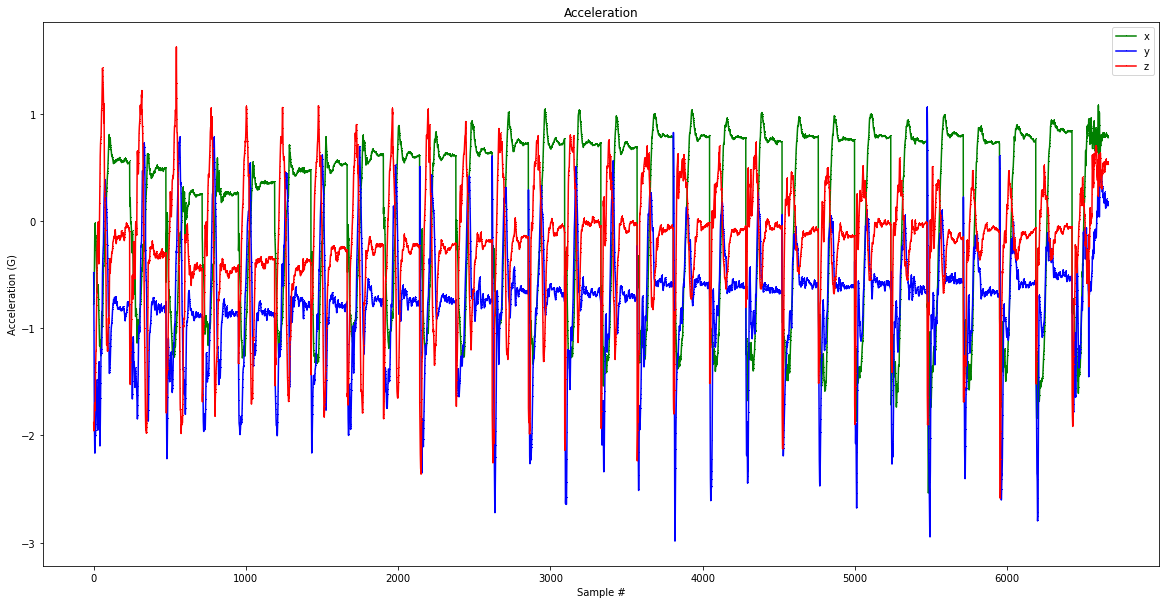

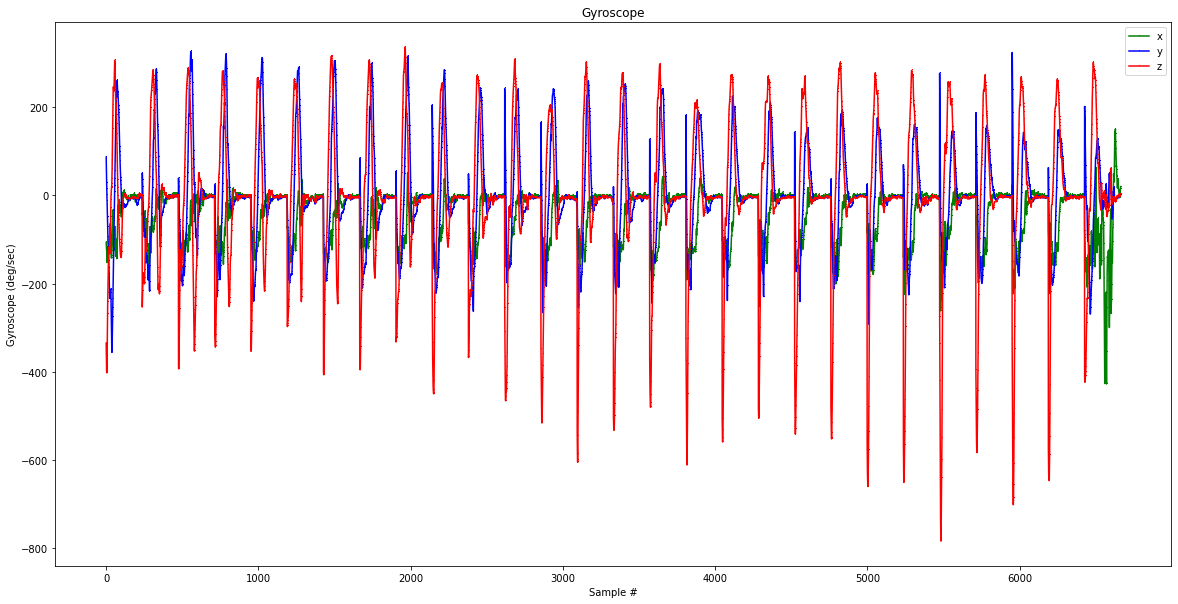

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "O_1.csv"

df = pd.read_csv("/content/" + filename)
df = df [239:]
df= df.dropna()

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [20]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
os.makedirs("/content/", exist_ok=True) 
df = pd.read_csv("/content/" + "O_1.csv")
df = df [239:]
df=df.dropna() 
df.to_csv('O_1_1.csv') 

In [21]:
len(df)

6664

In [34]:
df1 = pd.read_csv("/content/" + "X_1.csv")
df1 = df1.dropna() 
#df1 = df1 [239:]
df1.to_csv('X_1_1.csv') 

In [35]:
#len(df)
len(df1)

8092

## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "X_1_1",
    "O_1_1",
]

SAMPLES_PER_GESTURE = 238

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  #df =df.dropna()
  #df = df [239:]
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.0

Processing index 0 for gesture 'X_1_1'.
	There are 34 recordings of the X_1_1 gesture.
Processing index 1 for gesture 'O_1_1'.
	There are 28 recordings of the O_1_1 gesture.
Data set parsing and preparation complete.


### Run with Test Data
Put our test data into the model and plot the predictions


In [37]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)


inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [38]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/200
37/37 [==============================] - 1s 8ms/step - loss: 0.3265 - accuracy: 0.5405 - val_loss: 0.2775 - val_accuracy: 0.3077
Epoch 2/200
37/37 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.5946 - val_loss: 0.1694 - val_accuracy: 0.6923
Epoch 3/200
37/37 [==============================] - 0s 3ms/step - loss: 0.2211 - accuracy: 0.5946 - val_loss: 0.1772 - val_accuracy: 1.0000
Epoch 4/200
37/37 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 0.7568 - val_loss: 0.1016 - val_accuracy: 1.0000
Epoch 5/200
37/37 [==============================] - 0s 3ms/step - loss: 0.1319 - accuracy: 0.9189 - val_loss: 0.0628 - val_accuracy: 1.0000
Epoch 6/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0832 - accuracy: 0.9730 - val_loss: 0.0931 - val_accuracy: 0.8462
Epoch 7/200
37/37 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.9189 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 8/200
3

## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

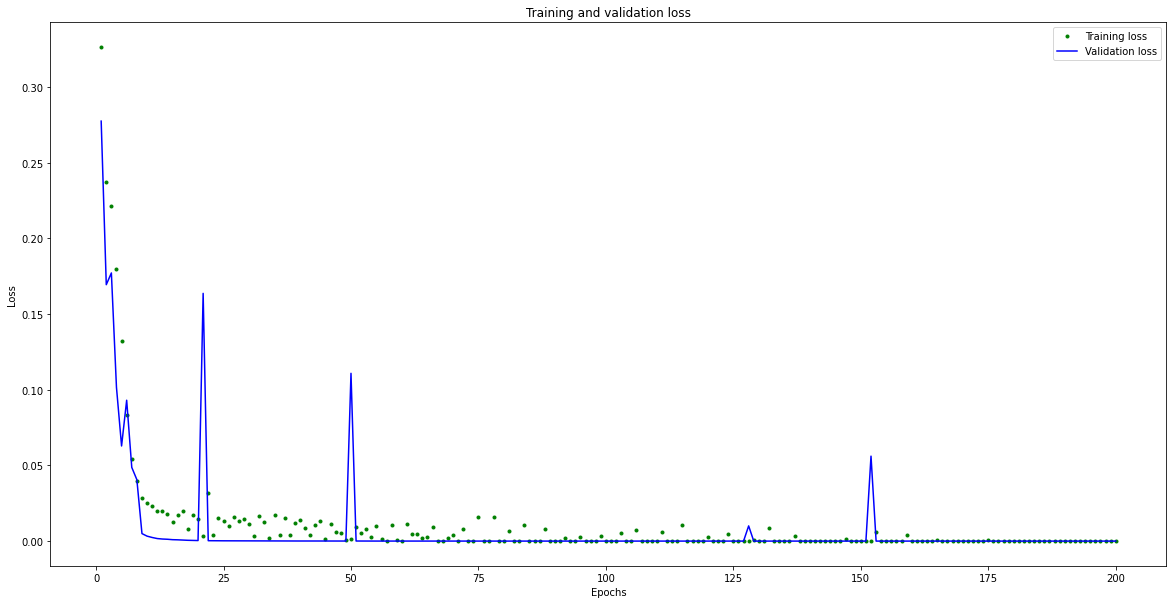

[20.0, 10.0]


In [39]:
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

predictions =
 [[0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.002 0.998]
 [0.    1.   ]]
actual =
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


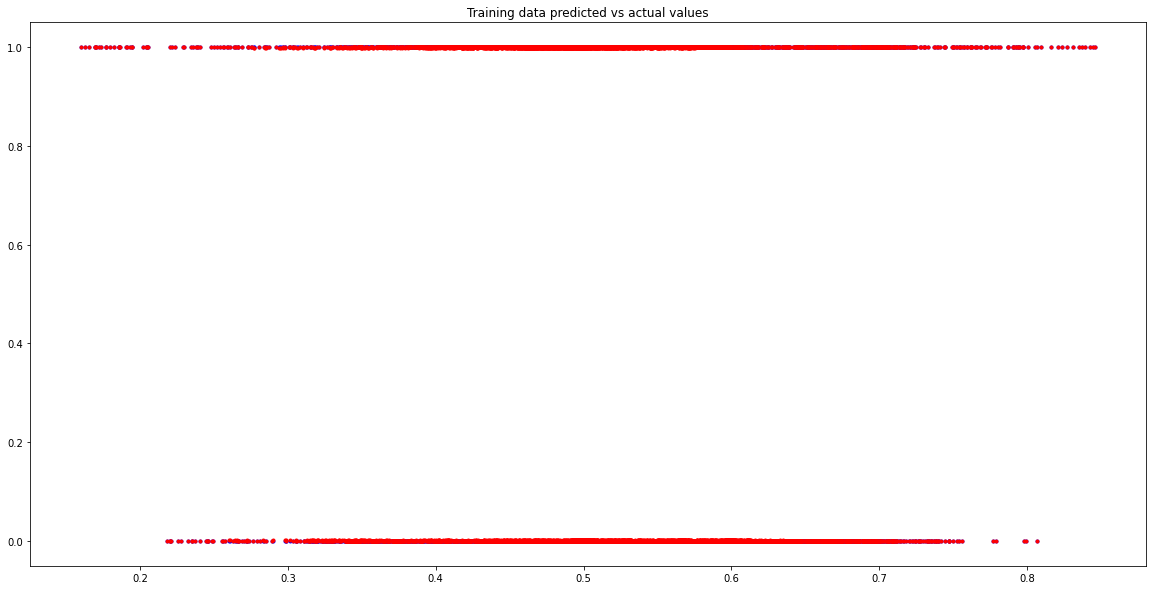

In [40]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Realtime Classification of Sensor Data on Arduino

Now it's time to switch back to the tutorial instructions and run our new model on the [Arduino Nano 33 BLE Sense](https://www.arduino.cc/en/Guide/NANO33BLE)

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)


INFO:tensorflow:Assets written to: /tmp/tmpmxjhtpd3/assets


Model is 290812 bytes


In [42]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,793,376 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
